<h1>
 O que é uma rede neural convolucional?
 <a id="intro" class="anchor-link" href="#intro">¶</a>
 </h1>
 <hr>

Uma rede neural convolucional (ou "convolutional neural network" (CNN) do inglês) é um tipo de neural network bastante aplicado em visão computacional, processamento de audio e ate mesmo para analise de séries temporais devido a seus excelentes resultados para problemas nessas áreas. Sua fundamentação se dá na operação matemática convolução (daí seu nome) e contém duas partes importantes:
 * Base: Convolutional layers 
 * Head: Fully conected layer
 
Em resumo, na base, as convolutional layers vão identificar diversos paramêtros (features) da camada de entrada e no head esses paramêtros são analisados e combinados para encontrar quais deles são relevantes para resolver o problema em questão. 

Nesse notebook, vamos estudar os conceitos básicos relacionados a CNN e então construir um modelo para identificar o tipo de flor baseado em imagens ;)

#### TABLE OF CONTENTS
* [O que é uma rede neural convolucional?](#def_conv)
* [O que é a convolução?](#def_conv)
* [Sobre a Convolutional Layer](#def_conv_layer)
* [Sobre a Fully Connected Layer](#def_full_conn)
* [Pooling Layers](#def_pool_layer)
* [Enfim, uma arquitetura CNN](#def_cnn)
* [Data Augmentation](#def_data_aug)
* [Transfer Learning](#def_tf)
* [Fine Tuning](#def_tuning)
* [Conclusão](#def_conc)

<h1>
 O que é a convolução?
 <a id="def_conv" class="anchor-link" href="#def_conv">¶</a>
 </h1>
 <hr>


A convolução é uma operação matemática utilizada para aplicar filtros em uma camada de entrada onde seus resultados vão gerar uma ativação. Podemos criar um simples filtro a partir da função tf.nn.conv2d

Um filtro é uma pequena matriz onde o valor dos números numa coluna ou linha informa o que queremos encontrar. Abaixo, o filtro da letra a), por exemplo, encontra apenas linhas horizontais (os números nas colunas tem soma igual a zero) já em b) encontra apenas linhas verticais (os números nas linhas tem soma igual a zero). 



![filtros](https://www.researchgate.net/profile/Edgar-Guevara-4/publication/328652857/figure/fig1/AS:688016486039552@1541047321056/Sobel-Masks-a-Horizontal-edge-and-b-Vertical-edge-detection.png)

<div class="alert alert-block alert-info" style="color:black; font-size:14px;">
    📌 O importante ao criar um filtro é que a somatória de todos os números dentro da matriz seja igual a zero. Então, é possível brincar com os números.
    <br>
    📌 Valores altos na matriz realçam melhor o filtro na imagem.
</div>

In [1]:
#imports 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

In [2]:
#imports 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import models
from scipy.ndimage import zoom


from keras.models import load_model

Fazendo uma aplicação da convolução em uma imagem

In [3]:
#carregando uma imagem e fazendo preprocessamento
exemple_img = tf.io.read_file("../input/flowers-recognition/flowers/dandelion/10486992895_20b344ce2d_n.jpg")
exemple_img = tf.io.decode_jpeg(exemple_img,channels=1)
exemple_img = tf.image.convert_image_dtype(exemple_img, dtype=tf.float32) #converte imagem para float32
exemple_img = tf.expand_dims(exemple_img,axis=0) #converte imagem para forma (batch,largura,comprimento,canais)

#Alguns filtros conhecidos 
#brinque com os filtros: descomente um deles (ou altere os valores) e aplique na função do kernel
horizontal_sobel = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
#vertical_sobel = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
#laplacian = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])

#Criando Filtro
kernel = tf.constant(horizontal_sobel)
kernel = tf.reshape(kernel,shape=[*kernel.shape,1,1]) #converte para shape (3,3,1,1)
kernel = tf.cast(kernel, dtype=tf.float32) #converte de inteiro para float32


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Aplicando a convolução em uma imagem

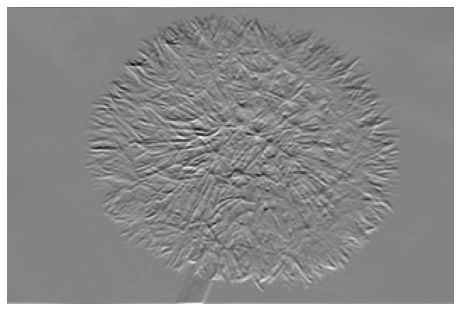

shape of the image: (1, 213, 320, 1)


In [4]:
#aplicando a convolução
img_filter = tf.nn.conv2d(input=exemple_img,filters=kernel,strides=1,padding="SAME")
plt.figure(figsize=(8,8))
plt.imshow(tf.squeeze(img_filter),cmap="gray")
plt.axis("off")
plt.show();
print("shape of the image:",img_filter.shape)

<div class="alert alert-block alert-info" style="color:black; font-size:14px;">
    Parâmetros importantes da convolução:
    <br>
     📌 A propriedade stride diz o quanto a matriz do filtro vai se deslocar ao fazer a varredura. ("a matriz pula um ou dois pixels?"). 
    <br>
     📌 A properidade padding adiciona mais pixeis na imagem para garantir com que a imagem resultante da convolução tenha o mesmo tamanho da imagem origem. Atenção: na função, tf.nn.conv2d, padding pode ser "VALID" ou "SAME", a primeira, não adiciona padding, já a última, adiciona padding.
     <br>
     📌 Diferentes combinações de padding e stride podem mexer nas dimensões da imagem. Para compreender isso melhor assista a esse <a href="https://youtu.be/tQYZaDn_kSg">video</a>. 
</div>

Uma outra técnica utilizada em conjunto com a convolução é a aplicação de uma função ativação sobre a imagem resultante da convolução. A ideia aqui é destacar o que foi encontrado ao aplicar o filtro na imagem.

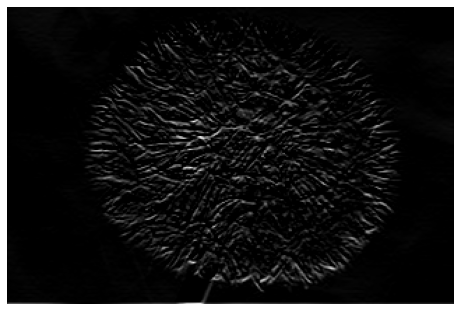

shape of the image: (1, 213, 320, 1)


In [5]:
#aplicando a RELU na imagem filtrada

img_detect = tf.nn.relu(img_filter)

plt.figure(figsize=(8, 8))
plt.imshow(tf.squeeze(img_detect),cmap="gray")
plt.axis("off")
plt.show();
print("shape of the image:",img_detect.shape)

<h1>
Sobre a Convolutional Layer
 <a id="def_conv_layer" class="anchor-link" href="#def_conv_layer">¶</a>
 </h1>
 <hr>

A ideia dela é utilizar diversas convoluções em conjunto para fazer a filtragem da camada de entrada e também se utilizar das funções de ativação para detectar features importantes. A junção de filtragem + ativação cria o que é chamado de feature map, ou seja, uma convolutional layer tem como resultado um conjunto de vários features maps para a camada de entrada.

Isso abre uma brecha importante: uma covolutional layer vai aprender os pesos necessários para encontrar os features mais importantes considerando a tarefa que ela quer resolver. Dessa forma, ela analisa a relação entre as diversas camadas de features maps e modifica os valores aplicados pelos kernels para melhor se ajustar a resolução do problema. 

<h1>
Sobre a Fully Connected Layer
 <a id="def_full_conn" class="anchor-link" href="#def_full_conn">¶</a>
 </h1>
 <hr>

As últimas camadas de uma arquitura de CNN são conhecidas como Head (ou top), a finalidade dela é justamente fazer a classificação das imagens. Ou seja, a partir dos features extraídos pelas convolutional layers, as últimas camadas irão 
determinar a qual classe é mais provável que a imagem pertença.

Essa última camada pode ser tanto uma dense layer mas também pode conter outras layers como dropout ou global pooling layers. 


<h1>
Pooling Layers
 <a id="def_pool_layer" class="anchor-link" href="#def_pool_layer">¶</a>
 </h1>
 <hr>

Em geral, não é só convolutional layes que vamos encontrar na camada base de uma CNN. Existem também as pooling layers. 

A pooling layer tem como função fazer o down sample da imagem, ou seja, diminuir a resolução da imagem. Isso é importante pois, a partir da convolução, pequenas mudanças (como rotação, alteração de cor e etc) na imagem geram novos features maps, uma consequência disso, é ter um aumento do tamanho do modelo mas com features que não trazem grande informação.

Logo, a ideia da pooling layer é atacar esse problema através da diminuição a resolução da imagem para manter apenas as informações importantes detectadas pela convolutional layer. Ou seja, ela condensa as informações detectadas pela convolutional layer.

Para fazer isso ela aplica uma pequena matriz na imagem original e utiliza um critério de decisão (valor maximo ou valor medio a exemplo) para selecionar os pixeis mais relevantantes. 


Isso traz uma vantagem relevante para as CNNs, elas aprendem que pequenas diferenças entre as distâncias dos pixels são indiferentes, ou seja, tanto faz se um feature localizado sofreu pequenas rotações ou aplicação de zoom. A CNN não vai diferenciar os features pela sua localização, ou seja, ele pode está localizado em diferentes posições da imagem mas para o classificador ele continua tendo o mesmo significado.


<div class="alert alert-block alert-info" style="color:black; font-size:14px;">
    📌 A prorpriedade da CNN de reconhecer os features em qualquer local da imagem é chamada de "translation invariance".
    <br>
    📌 A pooling layer retira parte da informação de espaço ao redor do feature mas não tudo. Ou seja, features que iniciam longe continuam longe
mesmo após diversas aplicações da pooling layer.
</div>

Algumas Pooling Layers mais utilizadas
* Max Pooling Layer: Divide a imagem em pequenos blocos e encontra neles o pixel de maior valor. 

* Average Pooling Layer : Divide a imagem em pequenos blocos e encontra o valor médio dos pixeis em cada bloco. 

* Global Pooling Layers: Aqui ela reduz os features maps para um simples número. Ela é utilizada para enfatizar para o modelo a presença do feature. Pode ser do tipo GlobalMaxPooling2D ou GlobalAveragePooling2D. As vezes, é utilizada no lugar da camada densa para classficar os features maps. Seu output para a GlobalMaxPooling2D é o valor máximo de ativação do feature map analisado. Já para a GlobalAveragePooling2D é o valor médio dos pixels de ativação  do feature map analiasado.


Realizando uma aplicação de pooling layer em uma imagem

(1, 107, 160, 1)


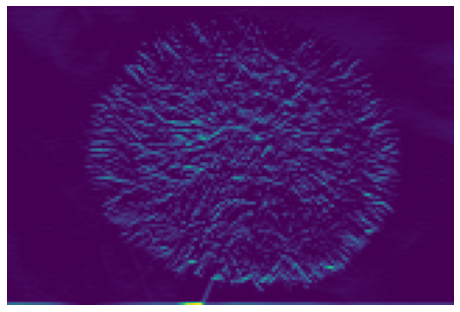

shape of the image: (1, 107, 160, 1)


In [6]:
img_condense = tf.nn.pool(
    input=img_detect, 
    window_shape=(2, 2),
    pooling_type='AVG', #você pode trocar para MAX
    strides=(2, 2), #a stride de (2,2) garante que a imagem tenha sua dimensão reduzida
    padding='SAME', 
)

print(img_condense.shape)
plt.figure(figsize=(8, 8))
plt.imshow(tf.squeeze(img_condense))
plt.axis('off')
plt.show();
print("shape of the image:",img_condense.shape)

<h1>
Enfim, uma arquitetura CNN
 <a id="def_cnn" class="anchor-link" href="#def_cnn">¶</a>
 </h1>
 <hr>

Observe o que fizemos com a flor de dandelion até aqui: 

1. Aplicamos um filtro de convolução e detectamos um feature da imagem, em seguida, aplicamos uma função de ativação para realçar o que foi encontrado pela convolução.
2.  Logo após, na imagem resultante da convolução + ativação é aplicada uma pooling layer (max ou avg) e temos uma imagem com o feature encontrado ainda mais realçado e em menor dimensão, ou seja, condensamos uma informação.

Em geral, a base da CNN tem essa forma: uma covolutional layer seguida de uma pooling layer. O processo descrito acima, é realizado várias vezes com diversos features. Inicialmente, as primeiras camadas de convolutional layer encontram parametros simples (bordas, linhas horizontais,pequenos circulos...), e em camadas superiores esses features simples geram features mais complexos (texturas, padrões de olhos, narizes etc..). 

Por fim, na head da CNN, temos uma fully connected layer (uma dense neural network) ou apenas uma global pooling layer junto com uma dense layer para realizar a classificação dos features encontrados. Assim, através dessa arquitetura, as CNNs tiveram grande sucesso para resolver problemas com diversos tipos de dados (principalmente com imagens) e diversos modelos foram criados melhorando cada vez as aplicações desse tipo de rede neural. 

<h1>
Data Augumentation
 <a id="def_data_aug" class="anchor-link" href="#def_data_aug">¶</a>
 </h1>
 <hr>

O data augumentation se resume em produzir artificialmente novas imagens de diferentes formatos em relação a original sem fazer com que ela perca seu significado 
de classificação. É uma técnica de preprocessamento para fazer com que a rede aprenda também outras formas de visualizar a camada de entrada e saber lidar com situações diferentes.
Algumas transformações feitas são: rotação da imagem, aplicação de zoom, alteração de largura e altura, aumentar/diminuir constraste e entre outras tecnicas.


Dito isso, não existe uma "receita de bolo" para decidir que tipo de técnica aplicar em todos os casos. É necessário avaliar o tipo de problema a ser resolvido.
A exemplo, em um problema de classificação para definir a diferença entre carros e motos, modificar a cor de uma imagem de carro não altera o significado da 
classificação (o carro continua sendo carro mesmo com cor diferente, certo?), contudo, para um problema de classificação de flores, a cor é um fator importante
de diferenciação (rosas podem ser amarelas mas girassóis por padrão são apenas amarelos). Logo, é importante avaliar caso a caso para encontrar as técnicas corretas
de data augumentation mas lembre-se: **a técnica aplicada não deve destruir o sentido de classificação da imagem**.

<h1>
Construindo uma CNN do zero 🛠
 <a id="def_build_cnn" class="anchor-link" href="#def_build_cnn">¶</a>
 </h1>
 <hr>

In [7]:
# Carregando dados de treinamento 
ds_train = image_dataset_from_directory(
    '../input/flowers-recognition/flowers',
    labels='inferred',
    label_mode = "categorical",
    image_size=[128, 128],
    validation_split = 0.3,
    subset="training",
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
    seed=42
)

Found 4317 files belonging to 5 classes.
Using 3022 files for training.


In [8]:
#carregando dados de validação 
ds_valid = image_dataset_from_directory(
    '../input/flowers-recognition/flowers',
    labels='inferred',
    label_mode = "categorical",
    image_size=[128, 128],
    validation_split = 0.3,
    subset="validation",
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
    seed=42
)

Found 4317 files belonging to 5 classes.
Using 1295 files for validation.


In [9]:
#analysing the class names 
class_names = ds_train.class_names
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [10]:
#seeing the shape of one vector 
for image,label in ds_train.take(1):
    print("shape:",image.shape)

2022-02-14 17:34:40.997794: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


shape: (64, 128, 128, 3)


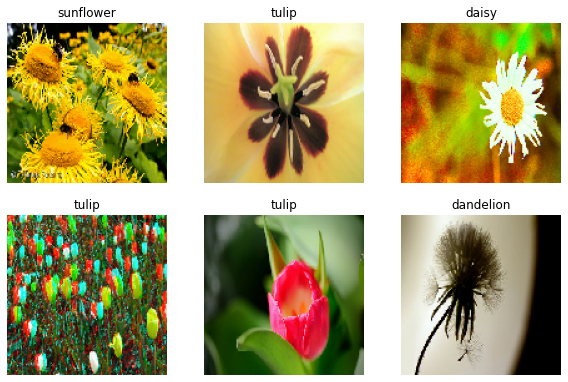

In [11]:
#seeing 5 images

for image,labels in ds_train.take(1):#getting one batch
    plt.figure(figsize=(10,10)) 
    for i in range(6): #show 6 images 
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy()) 
        plt.title(class_names[labels[i].numpy().tolist().index(1)])
        plt.axis("off")
        

In [12]:
#boas práticas para utlização dos dados 

# Vamos nos certificar de usar a pré-busca em buffer para que você possa gerar dados do disco sem que o I / O se torne um bloqueio. 
#Estes são dois métodos importantes que você deve usar ao carregar dados:

# Dataset.cache mantém as imagens na memória depois de serem carregadas fora do disco durante a primeira época. Isso garantirá que o conjunto de dados não se torne um gargalo durante o treinamento do seu modelo. Se o seu conjunto de dados for muito grande para caber na memória, você também pode usar este método para criar um cache em disco de alto desempenho.
# Dataset.prefetch sobrepõe dados de pré-processamento e execução do modelo durante o treinamento.

AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
ds_valid = ds_valid.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
#define o ramdomico das camadas 
tf.random.set_seed(42) 
np.random.seed(42)

In [14]:
#Camada de data augmentation
data_augmentation = keras.Sequential([
    preprocessing.RandomZoom(0.1),
    preprocessing.RandomFlip(mode="horizontal"),
    preprocessing.RandomRotation(factor=0.1),
    
])

2022-02-14 17:34:59.254234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 19 of 1000
2022-02-14 17:35:09.208807: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


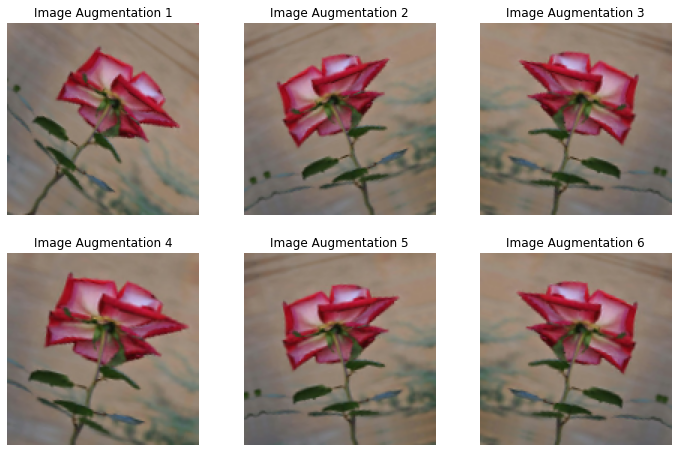

In [15]:
#Visualizando o data augumentation
all_images = [image for image,label in ds_train.take(-1)]
image = all_images[0][0]
plt.figure(figsize=(12,12)) 
for i in range(6): #mostra 6 data augumentations
    ax = plt.subplot(3,3,i+1)
    img_aug = data_augmentation(image)
    plt.imshow(img_aug) 
    plt.title(f"Image Augmentation {i+1}")
    plt.axis("off")
        

In [16]:
#Criação do Modelo!
model = keras.Sequential([
    
    
    layers.InputLayer(input_shape=[128, 128, 3]),
    
    #preprocessamento
    data_augmentation,
    
    layers.Rescaling(1./255),

    
    #Base,
    layers.BatchNormalization(),#camada de normalização dos dados
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'), 
    layers.MaxPool2D(),
    layers.Dropout(0.25),
    
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.25),
    
    

    
   
    # Head
    layers.BatchNormalization(),
    layers.GlobalMaxPooling2D(),
    layers.Dense(len(class_names),activation="softmax") #camada de output
])

<div class="alert alert-block alert-info" style="color:black; font-size:14px;">
    📌 A camada de output deve ter o mesmo tamanho da quantidade dos dados a serem classificados.
    <br>
    📌 Em geral, nas convolutional layers, a quantidade de filtros é aplicada em ordem crescente (64,128,256..) e são seguidas de pooling layers com strides de 2. Dessa forma, pouca memoria RAM é consumida (as pooling layers reduzem a dimensão da imagem e condensam as informações das covolutional layers) e mais reuniões de features são feitas nas camadas mais superiores (ou seja, mais parametros complexos são formados). Contudo, isso não é uma regra, é válido fazer vários testes com diferentes quantidade de filtros para saber qual é o melhor para seus dados. 
</div>

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (128, 128, 3)             0         
_________________________________________________________________
rescaling (Rescaling)        (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)       

In [18]:
#redução de learnng rate

#aqui é uma função para verificar quando devemos reduzir o learning rate, caso a val_loss não tenha mudanças por 2 epochs
#o lr é reduzido por um factor de 0.1
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001)

In [19]:
#definindo optimizador

#o adam é um algortimo de SGD com adaptative learning rate, apresenta um bom resultado para maioria dos problemas 
#sem necessitar ter muitos parametros para realizar hyperparametrização
optimizer = tf.keras.optimizers.Adam(epsilon=0.01,learning_rate=0.01)

In [20]:
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
    callbacks=[reduce_lr],
)

Epoch 1/30
48/48 [==============================] - 113s 2s/step - loss: 1.7114 - accuracy: 0.4411 - val_loss: 1.4518 - val_accuracy: 0.4201
Epoch 2/30
48/48 [==============================] - 110s 2s/step - loss: 1.1455 - accuracy: 0.5268 - val_loss: 1.3954 - val_accuracy: 0.4116
Epoch 3/30
48/48 [==============================] - 108s 2s/step - loss: 1.0998 - accuracy: 0.5606 - val_loss: 1.3695 - val_accuracy: 0.4154
Epoch 4/30
48/48 [==============================] - 110s 2s/step - loss: 1.0007 - accuracy: 0.5960 - val_loss: 1.2545 - val_accuracy: 0.4517
Epoch 5/30
48/48 [==============================] - 122s 3s/step - loss: 0.9571 - accuracy: 0.6234 - val_loss: 1.1111 - val_accuracy: 0.5923
Epoch 6/30
48/48 [==============================] - 119s 2s/step - loss: 0.9157 - accuracy: 0.6423 - val_loss: 1.0227 - val_accuracy: 0.6239
Epoch 7/30
48/48 [==============================] - 114s 2s/step - loss: 0.8971 - accuracy: 0.6565 - val_loss: 0.9773 - val_accuracy: 0.6378
Epoch 8/30
48

In [21]:
#classifcation  report 
test_images1 = [image.numpy() for image,labels in ds_valid.take(-1)][0]
test_labels1 = [labels.numpy() for image,labels in ds_valid.take(-1)][0]

test_labels1 = np.argmax(test_labels1,axis=-1)
predict_labels1 = np.argmax(model.predict(test_images1),axis=-1)

print(classification_report(test_labels1,predict_labels1,target_names=class_names))

              precision    recall  f1-score   support

       daisy       0.92      0.79      0.85        14
   dandelion       0.71      1.00      0.83         5
        rose       1.00      0.60      0.75        20
   sunflower       0.71      1.00      0.83        10
       tulip       0.53      0.67      0.59        15

    accuracy                           0.75        64
   macro avg       0.77      0.81      0.77        64
weighted avg       0.80      0.75      0.75        64



<AxesSubplot:title={'center':'Confusion Matrix for the test data'}>

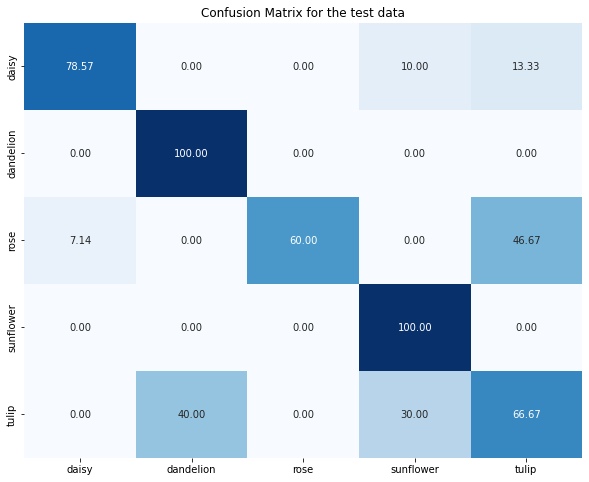

In [22]:
#plot da confusion matrix 
cn1 = confusion_matrix(test_labels1,np.argmax(model.predict(test_images1),axis=-1))
plt.figure(figsize=(10,8))
plt.title("Confusion Matrix for the test data")
sns.heatmap((cn1/np.sum(cn1,axis=-1)*100), annot=True, cmap='Blues',fmt=".2f",cbar=False,yticklabels=class_names,
           xticklabels=class_names)

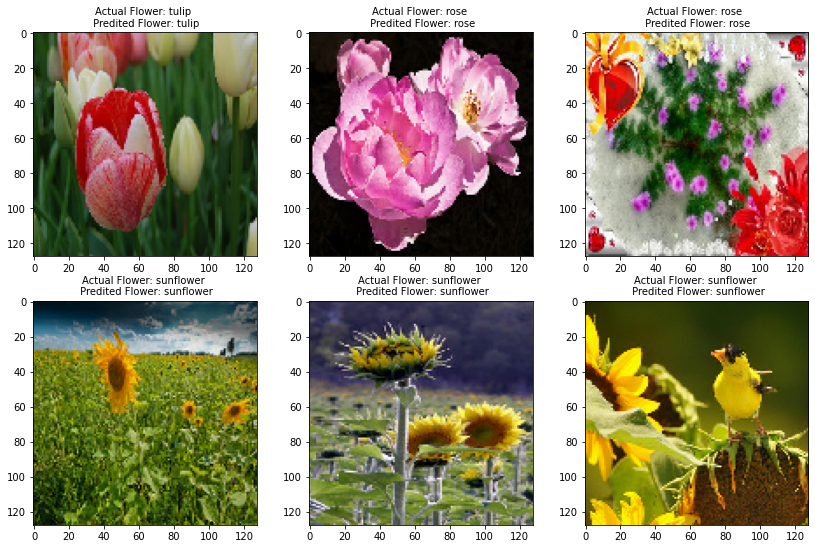

In [23]:
#Visualizando as predições 
plt.figure(figsize=(14,14)) 
for i in range(6): #show 6 images 
    ax = plt.subplot(3,3,i+1)
    plt.imshow(test_images1[i]) 
    plt.title(f"Actual Flower: {class_names[test_labels1[i]]} \n Predited Flower: {class_names[test_labels1[i]]}",
             fontsize=10)

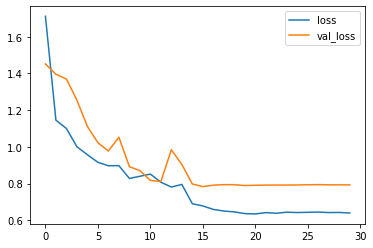

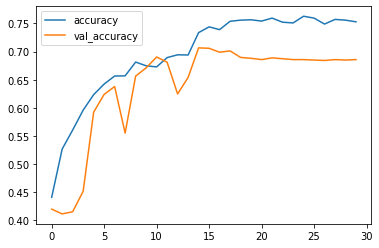

In [24]:
# Plot learning curves
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

<h1>
Transfer Learning
 <a id="def_tf" class="anchor-link" href="#def_tf">¶</a>
 </h1>
 <hr>

O transfer learning é uma técnica de deep learning muito utilizada para trabalhar com datasets pequenos. Ele consiste em utilizar uma
rede pre-treinada e reutilizar sua base convolucional, aplicar os dados de treinamento e treinar uma nova head da CNN. 

Em geral, essas redes pre-treinadas são modelos criados para lidaram com grande quantidade de imagens e resolver problemas mais complexos.
Sendo assim, é possível reaproveitar sua base convolucional pois em suas camadas temos aspectos mais generalistas das imagens. Lembre-se que as 
primeiras camadas contém features mais básicos das imagens (bordas, cores, linhas verticais...) e nas camadas superiores temos features mais complexos 
(textuas, localização dos olhos...) para problemas de visão computacional esses features podem ser reaproveitados para resolução de inumeros problemas.

Contudo, a camada head da rede pretreinada, de forma geral, não pode ser reaproveitada para o seu modelo de CNN.  Ela é treinada apenas para resolver um tipo de problema especifíco e nem sempre ele é igual ao seu. Então, não é possível reaproveitar seus pesos e por isso deve ocorrer um novo treino para sua rede aprender quais dos vários features encontrados na rede pretreinada é relevante para seu problema. 


Implementando o transfer learning

1 - Importamos a pre-trained base que nesse caso vai ser Xception, definimos a camada de entrada e não importamos a camada de head (include_top=False), já que queremos treinar a nossa propria camada de classificação para o problema. 

In [25]:
pretrained_base = keras.applications.xception.Xception(include_top=False,input_shape=(128,128,3),weights=None)

2 - No caso, como estamos trabalhando com o kaggle vamos importar a camada de peso da Xception, e carregar seus valores na pretrained_base

<div class="alert alert-block alert-info" style="color:black; font-size:14px;">
    📌 A Xception é uma abreviação do nome Extreme Xception e tem as mesmas ideias da Google Net e ResNet mas utiliza uma nova camada de convolução chamada de "depthwise separable convolution layer". Em uma convolutional layer normal, os filtros capturam simultaneamente spatial patterns (bordas, linhas horizontais..) e cross-channel patterns (como olhos+boca+nariz=rosto) o que pode ter um grande custo computacional. Já a depthwise separable convolution, divide essas operações em duas partes: primeiro, ela realiza a depthwise convolution, ou seja, um filtro é aplicado em cada canal da imagem, a procura das spatial patterns e, em seguida, aplica a pointwise convolution, onde o objetivo é reunir as inumeras aplicações de filtros a procura das cross-channels patterns. Dessa forma, é possível reduzir o custo computacional sem fazer com que a rede perca parâmetros importantes para o treino. (para entender melhor esse processo, recomendo o <a href="https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728">artigo</a>).
 </div>

In [26]:
weights_path = "../input/keraspretrainedmodel/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"
pretrained_base.load_weights(weights_path)

3 - Aqui é o passo mais importante! é necessário deixar as layers da base pre-treinada não treináveis, isso é necessário para definir os pesos das camadas de classificação da Head.

In [27]:
# não treinando as camadas do modelo base (pretrained_base)
for layer in pretrained_base.layers:
    layer.trainable = False

4 - Agora, é criado o modelo com a adição das camadas de Head e depois acontece o seu treino.

In [28]:
#adding a classification head 
inputs = keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
x = layers.Rescaling(scale=1./127.5,offset=-1)(x)
x = pretrained_base(x, training=False)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(class_names),activation="softmax")(x)
model_tl = tf.keras.Model(inputs, outputs)


In [29]:
model_tl.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (128, 128, 3)             0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
batch_normalization_7 (Batch (None, 4, 4, 2048)        8192      
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0     

In [30]:
model_tl.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=0.001),  
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)


In [31]:
reduce_lr_tf1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,min_delta=0.001,
                              patience=2, min_lr=0.0001)

In [32]:
#earlying stopping monitora a val_loss e verifica quando ela está parando de diminuir
#caso ela não esteja mais diminuindo, depois de uma quantidade x de vezes (parametro definido por patience) 
#o treino é parado e retorna o valor dos pesos para a epoch que
# que teve o melhor desempenho da metrica monitorada
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True,mode="min",
                                             min_delta=0.001)

In [33]:
history_tl = model_tl.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=25,
    callbacks=[reduce_lr_tf1,early_stop]
)

Epoch 1/25
48/48 [==============================] - 125s 3s/step - loss: 1.0793 - accuracy: 0.6075 - val_loss: 0.7332 - val_accuracy: 0.7181
Epoch 2/25
48/48 [==============================] - 125s 3s/step - loss: 0.7137 - accuracy: 0.7545 - val_loss: 0.6469 - val_accuracy: 0.7521
Epoch 3/25
48/48 [==============================] - 122s 3s/step - loss: 0.6365 - accuracy: 0.7776 - val_loss: 0.6032 - val_accuracy: 0.7722
Epoch 4/25
48/48 [==============================] - 123s 3s/step - loss: 0.6048 - accuracy: 0.7756 - val_loss: 0.5919 - val_accuracy: 0.7807
Epoch 5/25
48/48 [==============================] - 120s 3s/step - loss: 0.5548 - accuracy: 0.8064 - val_loss: 0.5842 - val_accuracy: 0.7846
Epoch 6/25
48/48 [==============================] - 122s 3s/step - loss: 0.5350 - accuracy: 0.8048 - val_loss: 0.5802 - val_accuracy: 0.7954
Epoch 7/25
48/48 [==============================] - 120s 3s/step - loss: 0.4950 - accuracy: 0.8150 - val_loss: 0.5795 - val_accuracy: 0.8093
Epoch 8/25
48

In [34]:
model_tl.save("my_model.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


<h1>
Fine Tuning
 <a id="def_tuning" class="anchor-link" href="#def_tuning">¶</a>
 </h1>
 <hr>

O fine tuning é um ajuste do modelo conseguido pelo Transfer Learning. Para melhorar ainda mais seus resultados. 

A ideia é deixar algumas camadas da base pretreinada treinaveis, mais precisamente, as camadas mais avançadas. A finalidade disso é ajustar o aprendizado de filtros mais complexos para o problema que queremos solucionar. Enquanto isso, como as camadas mais iniciais localizam features mais genéricos, não é preciso treina-las novamente, basta apenas reaproveitar esses padrões encontrados. 

<div class="alert alert-block alert-info" style="color:black; font-size:14px;">
    📌 O fine tuning só deve ser feito após a camada de Head ter sido treinada. Isso evita que você destrua o modelo pre-treinado porque você não está treinado a camada de base e head ao mesmo tempo e realizando uma modificação dos pesos já aprendidos anteriormente. 
    <br>
    📌O learning rate nessa etapa deve ser pequeno, já que apenas um ajuste está sendo feito, valores altos de learning rate podem fazer grandes modificações e as representações aprendidas pelas camadas da base sendo retreinadas agora podem ser destruídas. 
</div>

Implementando fine tuning

1 - Importando o modelo e visualizando a quantidade de camadas da base pretreinada

In [35]:
new_model = load_model("./my_model.h5")


print("Quantidade de camadas da pretrained_base:",len(pretrained_base.layers))

Quantidade de camadas da pretrained_base: 132


new_model.summary()

2 - Aqui realizamos o fine tuning. Escolhamos as últimas camadas da base pretreinada para serem treinadas

In [36]:
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (128, 128, 3)             0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
batch_normalization_7 (Batch (None, 4, 4, 2048)        8192      
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0     

In [37]:
#realizando ajuste fino apenas nas últimas camadas
fine_tune_at = 70

#new_model layer 3 is Xception
for layer in new_model.layers[3].layers[fine_tune_at:]:
    layer.trainable = True

3 - Rodamos novamente o modelo com um learning rate menor 

In [38]:
new_model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=0.0001,epsilon=0.001), #aplicando um learning rate menor
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)

In [39]:
reduce_lr_tl2 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.000001)

In [40]:
history_fine = new_model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=20,
    callbacks=[reduce_lr_tl2,early_stop]
)


Epoch 1/20
48/48 [==============================] - 228s 5s/step - loss: 0.3968 - accuracy: 0.8521 - val_loss: 0.5572 - val_accuracy: 0.8301
Epoch 2/20
48/48 [==============================] - 219s 5s/step - loss: 0.3280 - accuracy: 0.8802 - val_loss: 0.5510 - val_accuracy: 0.8309
Epoch 3/20
48/48 [==============================] - 241s 5s/step - loss: 0.2725 - accuracy: 0.8971 - val_loss: 0.5357 - val_accuracy: 0.8409
Epoch 4/20
48/48 [==============================] - 231s 5s/step - loss: 0.2098 - accuracy: 0.9312 - val_loss: 0.5078 - val_accuracy: 0.8556
Epoch 5/20
48/48 [==============================] - 221s 5s/step - loss: 0.1927 - accuracy: 0.9302 - val_loss: 0.4879 - val_accuracy: 0.8656
Epoch 6/20
48/48 [==============================] - 240s 5s/step - loss: 0.1632 - accuracy: 0.9398 - val_loss: 0.5096 - val_accuracy: 0.8517
Epoch 7/20
48/48 [==============================] - 220s 5s/step - loss: 0.1355 - accuracy: 0.9547 - val_loss: 0.4753 - val_accuracy: 0.8734
Epoch 8/20
48

In [41]:
#classifcation  report 
test_images2 = [image.numpy() for image,labels in ds_valid.take(-1)][0]
test_labels2 = [labels.numpy() for image,labels in ds_valid.take(-1)][0]

test_labels2 = np.argmax(test_labels2,axis=-1)
predict_labels2 = np.argmax(new_model.predict(test_images2),axis=-1)

print(classification_report(test_labels2,predict_labels2,target_names=class_names))

              precision    recall  f1-score   support

       daisy       1.00      0.86      0.92        14
   dandelion       0.56      1.00      0.71         5
        rose       0.94      0.80      0.86        20
   sunflower       0.91      1.00      0.95        10
       tulip       0.93      0.93      0.93        15

    accuracy                           0.89        64
   macro avg       0.87      0.92      0.88        64
weighted avg       0.92      0.89      0.90        64



<AxesSubplot:title={'center':'Confusion Matrix for the test data'}>

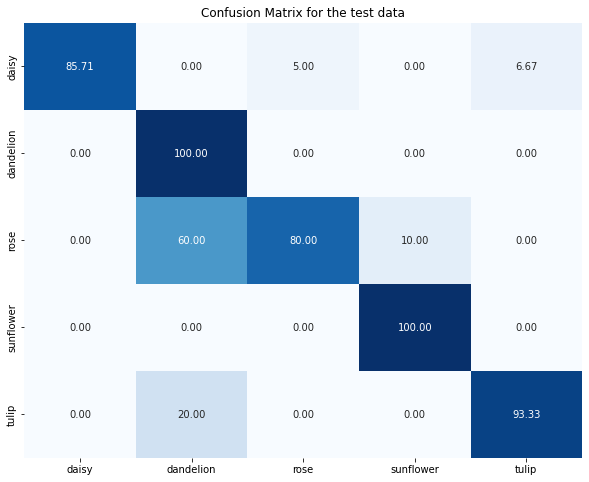

In [42]:
#plot da confusion matrix 
cn2 = confusion_matrix(test_labels2,np.argmax(new_model.predict(test_images2),axis=-1))
plt.figure(figsize=(10,8))
plt.title("Confusion Matrix for the test data")
sns.heatmap((cn2/np.sum(cn2,axis=-1)*100), annot=True, cmap='Blues',fmt=".2f",cbar=False,yticklabels=class_names,
           xticklabels=class_names)

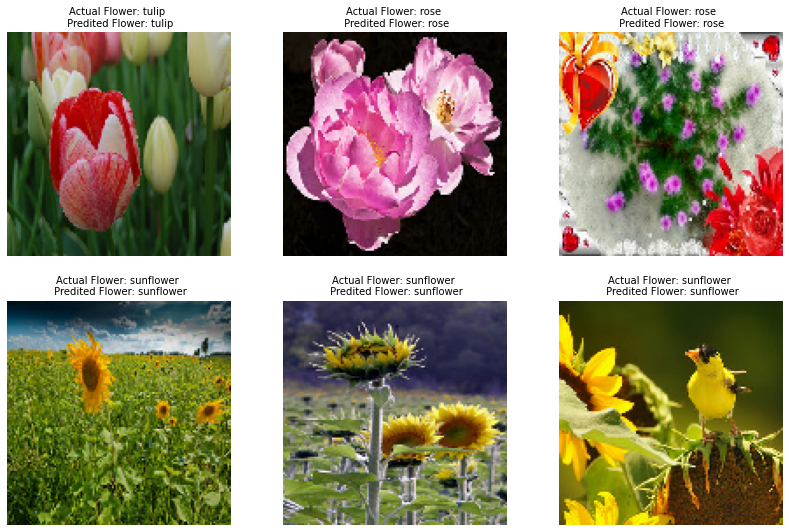

In [43]:
#Visualizando as predições 
plt.figure(figsize=(14,14)) 
for i in range(6): #show 6 images 
    ax = plt.subplot(3,3,i+1)
    plt.imshow(test_images2[i]) 
    plt.title(f"Actual Flower: {class_names[test_labels2[i]]} \n Predited Flower: {class_names[test_labels2[i]]}",
             fontsize=10)
    plt.axis("off")

In [44]:
#resumindo os dados de loss e accuracy
loss,acc = new_model.evaluate(ds_valid)
print(f"the final loss is {loss:.3f}")
print(f"the final accuracy is {acc:.3f}")

21/21 [==============================] - 40s 2s/step - loss: 0.4753 - accuracy: 0.8734
the final loss is 0.475
the final accuracy is 0.873


<h1>
Conclusão
 <a id="def_conc" class="anchor-link" href="#def_conc">¶</a>
 </h1>
 <hr>

As redes neurais convolucionais como podemos perceber são bastantes úteis para resolver uma gama de problemas, princialmente, aqueles com imagens. Nesse caso, mesmo com uma grande quantidade de dados atráves dessa arquitetura é possível obter excelentes resultados utilizando pouca memória e tempo de processamento. 

Dito isso, a partir do dataset de flores podemos perceber quão eficiente são as CNNs. Utilizando apenas convolutional layers e pooling layers conseguimos obter um bom modelo com acurácia em torno de 70%. 

E por fim, vimos o quão eficaz o transfer learning pode ser para esse tipo de arquitetura, devido as CNNs aprenderem tanto características gerais quanto padrões mais especificos dos dados podemos reaproveitar modelos e utilizá-los para resolver o nosso problema. O combo transfer learning e fine tuning se mostrou poderoso para a classificação que fizemos. Com poucas epochs conseguimos obter um excelente modelo reaproveitando a estrutura da Xception. Assim, mesmo com uma quantidade pequena de imagens foi possível construir uma CNN bastante eficiente, o que demonstra o porquê delas serem tão discutidas e estudadas. 